In [26]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-price-prediction-challenge/sample_submission.csv
/kaggle/input/house-price-prediction-challenge/train.csv
/kaggle/input/house-price-prediction-challenge/test.csv


### Downloading Dataset

In this section, we use the `kagglehub` library to download the latest version of the "House Price Prediction Challenge" dataset. This library allows us to directly download datasets from Kaggle without needing to manually upload files to the notebook.

- `kagglehub.dataset_download()`: This function downloads the dataset specified by the Kaggle dataset identifier `"anmolkumar/house-price-prediction-challenge"`.
- After the download, the dataset's path is printed to confirm where the files have been stored locally in the notebook environment.

In [27]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("anmolkumar/house-price-prediction-challenge")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/house-price-prediction-challenge


## Importing Required Libraries

In this section, we import several Python libraries and modules that are essential for data manipulation, visualization, machine learning, and evaluation.

- `pandas`: Used for data manipulation and analysis, especially for handling DataFrame objects.
- `numpy`: Provides support for large, multi-dimensional arrays and matrices, as well as mathematical functions to operate on these arrays.
- `seaborn`: A statistical data visualization library based on `matplotlib` that provides a high-level interface for drawing attractive and informative statistical graphics.
- `matplotlib.pyplot`: A plotting library used for creating static, animated, and interactive visualizations in Python.
- `plotly.express`: A library used to create interactive visualizations.
- `scipy.stats`: Contains a large number of statistical functions for hypothesis testing, distributions, and more.
- `joblib`: Used for saving (dump) and loading models (load), which is essential for model persistence and sharing.
- `sklearn`: A collection of machine learning algorithms and tools for model building, preprocessing, and evaluation. Specifically:
    - **Impute**: For handling missing data.
    - **Pipeline**: To build end-to-end machine learning workflows.
    - **ColumnTransformer**: For applying transformations to specific subsets of features.
    - **RobustScaler**: A scaler that removes the median and scales the data according to the interquartile range (useful for robust machine learning).
    - **OneHotEncoder**: A method for encoding categorical features.
    - **DummyRegressor**: A baseline model for regression that predicts the mean of the target variable.
    - **RandomForestRegressor**: A machine learning model for regression that uses an ensemble of decision trees.
    - **GridSearchCV**: For hyperparameter tuning using cross-validation.
    - **cross_val_score**: For evaluating model performance using cross-validation.
    - **train_test_split**: To split the dataset into training and testing sets.
    - **mean_squared_error** and **r2_score**: Common evaluation metrics for regression models.

In [67]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import scipy.stats as stats

from joblib import dump
from joblib import load
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, r2_score

## Reducing Memory Usage

In this section, we define a function `reduce_memory_usage` that aims to optimize memory usage by downcasting numeric data types. This is particularly useful when working with large datasets, as it helps reduce the memory footprint by converting columns to smaller data types (e.g., `int64` to `int32` or `float64` to `float32`).

- **Downcasting**: By converting columns to smaller data types, we can significantly reduce the memory consumption of our DataFrame without losing much precision.


In [ ]:
# Reduce memory usage by downcasting numeric types
def reduce_memory_usage(df):
    for col in df.select_dtypes(include=['int', 'float']).columns:
        col_min = df[col].min()
        col_max = df[col].max()
        if pd.api.types.is_integer_dtype(df[col]):
            df[col] = pd.to_numeric(df[col], downcast='integer')
        else:
            df[col] = pd.to_numeric(df[col], downcast='float')
    return df

## Wrangle Function

In this section, we define the `wrangle` function, which is responsible for loading, cleaning, and transforming the dataset before any analysis or modeling. This function handles several preprocessing steps to ensure the dataset is ready for further analysis and modeling tasks.

Here’s a breakdown of the key steps:


In [71]:
# Define the 'wrangle' function to load and clean the data
def wrangle(filepath):
    try:
        # Read the CSV file into a DataFrame, handling missing values as 'NA'
        df = pd.read_csv(filepath, na_values=['', 'NA', 'NaN'])
    except FileNotFoundError as e:
        print(f"Error: File not found -> {e.filename}")
        return pd.DataFrame()

    # Mask missing values (NaN) with pandas' native NA
    df = df.mask(df.isna(), pd.NA)

    # Output the basic shape and summary statistics of the data
    print(f"Shape: {df.shape}")
    print(df.describe())
    print("\nMissing values (% per column):")
    print(df.isna().mean().mul(100).sort_values(ascending=False).loc[lambda x: x > 0])

    # Identify numeric and categorical columns
    num_cols = df.select_dtypes(include=[np.number]).columns
    cat_cols = df.select_dtypes(include='object').columns

    # Impute missing numeric values with the median if missing percentage is below 20%
    for col in num_cols:
        missing_pct = df[col].isna().mean()
        if 0 < missing_pct < 0.2:
            imputer = SimpleImputer(strategy='median')
            df[col] = imputer.fit_transform(df[[col]])

    # Impute missing categorical values with 'Unknown' if missing percentage is above 20%
    for col in cat_cols:
        missing_pct = df[col].isna().mean()
        if missing_pct > 0.2:
            df[col] = df[col].fillna("Unknown")

    # Create a new feature 'POSTED_BY_GROUPED' to group 'POSTED_BY' column values
    if 'POSTED_BY' in df.columns:
        df['POSTED_BY_GROUPED'] = df['POSTED_BY'].apply(lambda x: 'Dealer' if x == 'Dealer' else 'Non-Dealer')
        df.drop(columns=['POSTED_BY'], inplace=True)

    # Handle outliers in the key features 'TARGET(PRICE_IN_LACS)' and 'SQUARE_FT' using IQR
    key_features = ['TARGET(PRICE_IN_LACS)', 'SQUARE_FT']
    for feature in key_features:
        if feature in df.columns:
            Q1 = df[feature].quantile(0.25)
            Q3 = df[feature].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            df = df[df[feature].between(lower_bound, upper_bound)]

    # Create a new feature 'Price_per_sqft' to represent price per square foot
    if 'TARGET(PRICE_IN_LACS)' in df.columns and 'SQUARE_FT' in df.columns:
        df['Price_per_sqft'] = df['TARGET(PRICE_IN_LACS)'] / df['SQUARE_FT']

    # Drop unnecessary columns like "UNDER_CONSTRUCTION", "RESALE", etc.
    for col in ["UNDER_CONSTRUCTION", "RESALE", "RERA","Price_per_sqft", "BHK_OR_RK"]:
        if col in df.columns:
            df.drop(columns=[col], inplace=True)

    # Split the 'ADDRESS' column to extract the last part (city or region)
    df["address"] = df["ADDRESS"].str.split(",").str[-1].str.strip()  
    df.drop(columns=["ADDRESS"], inplace=True)

    # Reduce memory usage by downcasting numeric columns
    df = reduce_memory_usage(df)

    # Assert there are no missing values left
    assert df.isna().sum().sum() == 0, "There are still missing values in the dataset."

    return df


## Wrangle Data and Preview the First Few Rows

In this step, we call the `wrangle` function on the training dataset located at the specified path. The function will process the data and return a cleaned DataFrame. Once the wrangling is complete, we preview the first few rows of the cleaned dataset using `df.head()` to verify that the data has been cleaned and transformed as expected.

### Code to Wrangle and Preview:


In [73]:
# Wrangle the dataset and preview the first few rows
df = wrangle("/kaggle/input/house-price-prediction-challenge/train.csv")

# Display the first few rows of the cleaned dataset
df.head()


Shape: (29451, 12)
       UNDER_CONSTRUCTION          RERA       BHK_NO.     SQUARE_FT  \
count        29451.000000  29451.000000  29451.000000  2.945100e+04   
mean             0.179756      0.317918      2.392279  1.980217e+04   
std              0.383991      0.465675      0.879091  1.901335e+06   
min              0.000000      0.000000      1.000000  3.000000e+00   
25%              0.000000      0.000000      2.000000  9.000211e+02   
50%              0.000000      0.000000      2.000000  1.175057e+03   
75%              0.000000      1.000000      3.000000  1.550688e+03   
max              1.000000      1.000000     20.000000  2.545455e+08   

       READY_TO_MOVE        RESALE     LONGITUDE      LATITUDE  \
count   29451.000000  29451.000000  29451.000000  29451.000000   
mean        0.820244      0.929578     21.300255     76.837695   
std         0.383991      0.255861      6.205306     10.557747   
min         0.000000      0.000000    -37.713008   -121.761248   
25%        

,BHK_NO.,SQUARE_FT,READY_TO_MOVE,LONGITUDE,LATITUDE,TARGET(PRICE_IN_LACS),POSTED_BY_GROUPED,address
0,2,1300.236450,1,12.969910,77.597961,55.0,Non-Dealer,Bangalore
1,2,1275.000000,1,12.274538,76.644608,51.0,Dealer,Mysore
2,2,933.159729,1,12.778033,77.632195,43.0,Non-Dealer,Bangalore
3,2,929.921143,1,28.642300,77.344498,62.5,Non-Dealer,Ghaziabad
4,2,999.009277,0,22.592199,88.484909,60.5,Dealer,Kolkata


In [31]:
df.dtypes

BHK_NO.                     int8
SQUARE_FT                float32
READY_TO_MOVE               int8
LONGITUDE                float32
LATITUDE                 float32
TARGET(PRICE_IN_LACS)    float32
POSTED_BY_GROUPED         object
address                   object
dtype: object

In [ ]:
df["BHK_OR_RK"].value_counts()

In [34]:
df["POSTED_BY_GROUPED"].value_counts()

POSTED_BY_GROUPED
Dealer        14894
Non-Dealer    10681
Name: count, dtype: int64

## Visualizing Class Balance for "BHK_OR_RK"

In this step, we plot a bar chart to examine the distribution of property types in the "BHK_OR_RK" column. The purpose of this visualization is to check for class balance or imbalance in the dataset.

1. **Value Counts**: We use the `value_counts(normalize=True)` method to calculate the frequency distribution of the values in the "BHK_OR_RK" column. The `normalize=True` parameter scales the counts to show the relative frequencies (percentages) rather than the absolute counts.

2. **Bar Plot**: We then plot the class balance using a bar chart (`kind="bar"`) with labels for the x-axis ("Type of property") and y-axis ("Frequency"). The title "Class Balance" is added to describe the purpose of the chart.

This bar chart will help us understand how the data is distributed between the different types of properties and if any preprocessing (like dealing with class imbalance) is necessary.


In [ ]:
df["BHK_OR_RK"].value_counts(normalize=True).plot(
    kind = "bar",
    xlabel = "Type of property",
    ylabel = "Frequency",
    title = "Class Balance"
);

## Visualizing the Distribution of "TARGET(PRICE_IN_LACS)"

In this step, we plot the distribution of the target variable, "TARGET(PRICE_IN_LACS)," which likely represents the house prices in lakhs. Understanding the distribution of the target variable is essential to decide the modeling techniques and potential data transformations.

1. **Histogram with KDE**: We use `sns.histplot` to plot the distribution of the target variable. The histogram shows the frequency distribution of house prices, while the kernel density estimate (KDE) curve provides a smooth estimation of the probability density function.

2. **Bins and Size**: We set the number of bins to 30 for better granularity and adjust the figure size to `(10, 5)` for better readability.

3. **Title and Labels**: The plot title is set to "TARGET(PRICE_IN_LACS) Distribution with KDE" to describe the visualization. The x-axis is labeled as "TARGET(PRICE_IN_LACS)" to indicate the variable being plotted.

This visualization helps us understand the spread of house prices and whether the data is skewed or follows a certain distribution, such as normal or log-normal. It also helps in identifying outliers or extreme values in the target variable.


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



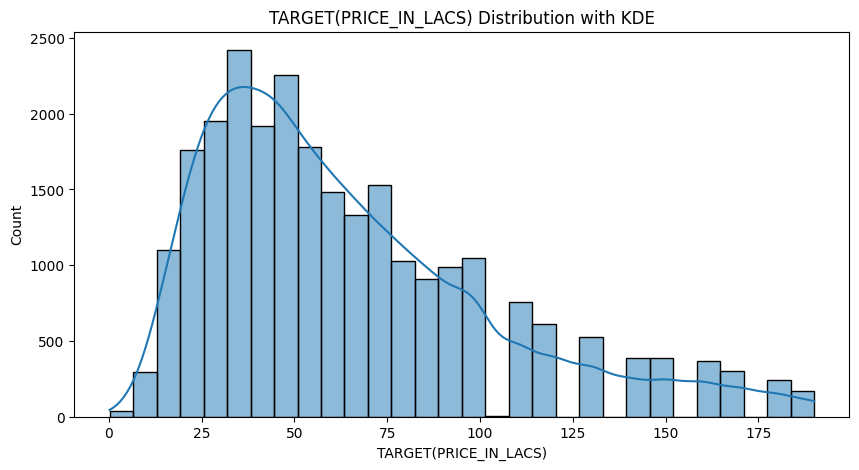

In [36]:
# Distribution of TARGET(PRICE_IN_LACS)
plt.figure(figsize=(10, 5))
sns.histplot(df['TARGET(PRICE_IN_LACS)'], kde=True, bins=30)
plt.title("TARGET(PRICE_IN_LACS) Distribution with KDE")
plt.xlabel("TARGET(PRICE_IN_LACS)")
plt.show()


## Visualizing the Mean Price by Address

In this section, we calculate and visualize the average house price for each unique address (from the `address` column) in the dataset. This can give us an understanding of the pricing trend across different locations. For the visualization, we sort the addresses based on the mean price and then plot a line graph.

1. **Calculate Mean Price per Address**: We group the data by the "address" column and compute the mean of the "TARGET(PRICE_IN_LACS)" for each address. The result is sorted in ascending order to identify which locations have higher or lower average house prices.

2. **Line Graph**: The line graph is plotted using the calculated mean prices, with the x-axis representing the sorted addresses (by index) and the y-axis representing the mean price. Markers are added to each data point for clarity.

3. **Top and Bottom Cities**: We display the top 5 addresses with the highest mean prices and the bottom 5 addresses with the lowest mean prices for a quick overview.

This visualization helps us to identify locations where house prices are significantly higher or lower than the average. It also assists in detecting any trends or patterns related to geographical areas and house pricing.


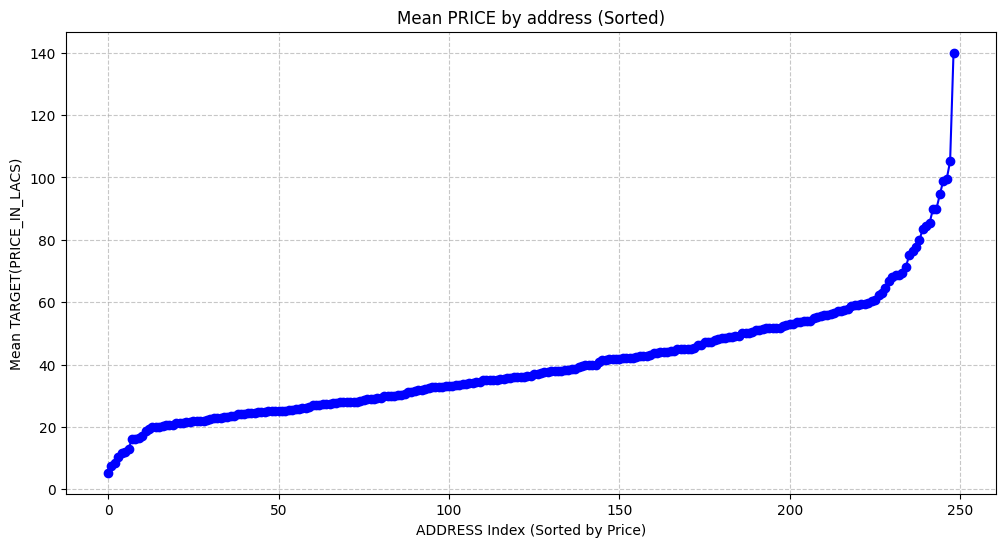

Top 5 Cities by Mean PRICE:
         address  TARGET(PRICE_IN_LACS)
239       Panaji              83.457687
240       Idukki              84.500000
241        Arrah              85.500000
242     Srinagar              90.000000
243       Hassan              90.000000
244     Lalitpur              94.582748
245       Mumbai              99.004135
246  Maharashtra              99.531929
247      Gurgaon             105.158470
248      Hathras             140.000000

Bottom 5 Cities by Mean PRICE:
       address  TARGET(PRICE_IN_LACS)
0      Bankura                   5.30
1         Pali                   7.40
2        Korba                   8.50
3         Bhuj                  10.50
4    Barabanki                  11.75
5      Hajipur                  12.00
6    Gurdaspur                  13.05
7     Banswara                  16.00
8        Harda                  16.00
9  Sabarkantha                  16.50


In [37]:
# Calculate mean PRICE per ADDRESS_1 and sort
address1_price = df.groupby('address')['TARGET(PRICE_IN_LACS)'].mean().sort_values().reset_index()

# Line graph
plt.figure(figsize=(12, 6))
plt.plot(address1_price.index, address1_price['TARGET(PRICE_IN_LACS)'], marker='o', linestyle='-', color='b')
plt.title('Mean PRICE by address (Sorted)')
plt.xlabel('ADDRESS Index (Sorted by Price)')
plt.ylabel('Mean TARGET(PRICE_IN_LACS)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Top and bottom 5 for reference
print("Top 5 Cities by Mean PRICE:")
print(address1_price.tail(10))
print("\nBottom 5 Cities by Mean PRICE:")
print(address1_price.head(10))

## Correlation Heatmap

In this section, we analyze the relationships between different numerical features and their correlation with the target variable, `TARGET(PRICE_IN_LACS)`.

1. **Correlation Calculation**: We compute the correlation matrix for the numerical features in the dataset. Correlation measures the strength and direction of the linear relationship between two variables, with values ranging from -1 (perfect negative correlation) to 1 (perfect positive correlation).

2. **Select Top Correlated Features**: We specifically focus on the features that have the highest absolute correlation with the target variable (`TARGET(PRICE_IN_LACS)`). These are the features most likely to influence the price.

3. **Heatmap Visualization**: The heatmap is then generated to visualize the correlation matrix for the top correlated features. The intensity of the colors (from blue to red) represents the strength of the correlation, with blue indicating negative correlation and red indicating positive correlation.

4. **Key Insights**: By visualizing these relationships, we can identify which features have the strongest influence on house prices. This can help in building a better predictive model by focusing on the most important features.

### Key Takeaways:
- The heatmap provides a clear understanding of which features correlate strongly with `TARGET(PRICE_IN_LACS)`.
- Features that show a high correlation with the target are often the most influential for predicting house prices, and thus should be prioritized in model development.


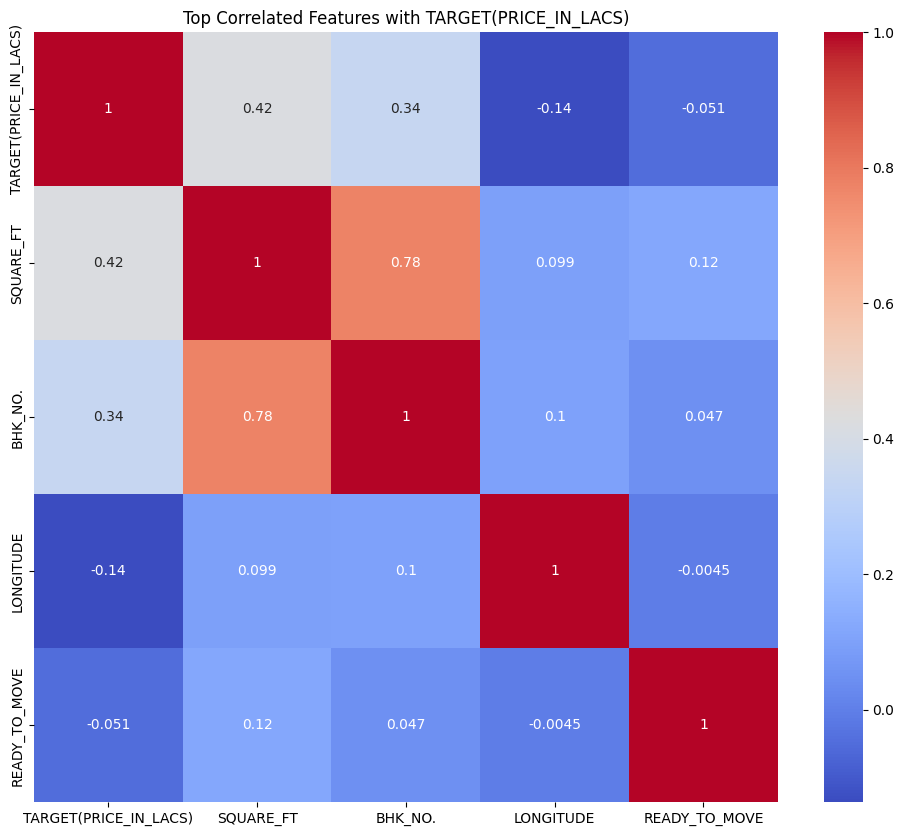

In [75]:
# Correlation heatmap
plt.figure(figsize=(12, 10))
corr = df.corr(numeric_only=True)
top_corr = corr['TARGET(PRICE_IN_LACS)'].abs().sort_values(ascending=False).head().index
sns.heatmap(df[top_corr].corr(), annot=True, cmap='coolwarm')
plt.title("Top Correlated Features with TARGET(PRICE_IN_LACS)")
plt.show()

## Statistical Test Results

In this section, we perform statistical tests to assess the relationships between different features and the target variable, `TARGET(PRICE_IN_LACS)`.

1. **ANOVA (Analysis of Variance)**: 
   - We apply ANOVA to categorical features with more than one unique value to determine whether the mean `TARGET(PRICE_IN_LACS)` differs significantly across the categories. A low p-value (typically < 0.05) indicates that there is a significant difference in the mean target variable across the categories.
   
2. **Pearson's Correlation**: 
   - Pearson's test measures the linear correlation between two variables. A low p-value (< 0.05) indicates that there is a statistically significant linear relationship between the numeric feature and the target variable.

3. **Spearman's Rank Correlation**: 
   - Spearman's correlation assesses the monotonic relationship between two variables, which can capture non-linear but still ordered relationships. Like Pearson's, a low p-value suggests a significant correlation.

4. **Sorting the Results**: 
   - After performing the tests, the results are organized in a table and sorted by the p-value, with the most statistically significant results appearing at the top.

### Key Observations:
- **Significant Categorical Variables**: Features like `POSTED_BY_GROUPED` and `address` show very low p-values (close to 0), indicating that they have a significant influence on the target variable.
  
- **Significant Numeric Variables**: Features such as `BHK_NO.` and `SQUARE_FT` have p-values of 0, showing a strong linear relationship with the target variable. Additionally, geographical features like `LATITUDE` and `LONGITUDE` also have very low p-values, suggesting their significant impact on property prices.

By identifying the significant features through statistical tests, we can prioritize them when building predictive models.



In [39]:
# Statistical tests table
anova_results = []
num_corr_results = []
for col in df.columns:
    if df[col].dtype == 'object':
        if df[col].nunique() > 1:
            grouped = df[[col, 'TARGET(PRICE_IN_LACS)']].dropna().groupby(col)
            if len(grouped) > 1:
                f_val, p_val = stats.f_oneway(*(grouped['TARGET(PRICE_IN_LACS)'].apply(list)))
                anova_results.append({'Feature': col, 'Test': 'ANOVA', 'P-Value': p_val})
    elif pd.api.types.is_numeric_dtype(df[col]) and col != 'TARGET(PRICE_IN_LACS)':
        pearson = stats.pearsonr(df[col], df['TARGET(PRICE_IN_LACS)'])[1]
        spearman = stats.spearmanr(df[col], df['TARGET(PRICE_IN_LACS)'])[1]
        num_corr_results.append({'Feature': col, 'Test': 'Pearson', 'P-Value': pearson})
        num_corr_results.append({'Feature': col, 'Test': 'Spearman', 'P-Value': spearman})

stats_df = pd.DataFrame(anova_results + num_corr_results)
print("\nStatistical Test Results:")
print(stats_df.sort_values("P-Value").head(10))



Statistical Test Results:
              Feature      Test        P-Value
0   POSTED_BY_GROUPED     ANOVA   0.000000e+00
1             address     ANOVA   0.000000e+00
2             BHK_NO.   Pearson   0.000000e+00
3             BHK_NO.  Spearman   0.000000e+00
4           SQUARE_FT   Pearson   0.000000e+00
5           SQUARE_FT  Spearman   0.000000e+00
9           LONGITUDE  Spearman  2.526236e-141
8           LONGITUDE   Pearson  1.007301e-106
11           LATITUDE  Spearman   3.057355e-55
6       READY_TO_MOVE   Pearson   3.723583e-16


## Feature/Target Split

In this step, we separate the features (input variables) and the target (output variable) that we aim to predict. 

1. **Target Variable**:
   - The target variable is the column `TARGET(PRICE_IN_LACS)`, which represents the property prices in the dataset.
   - This is the variable we want to predict using the features (input variables).

2. **Feature Variables**:
   - All other columns except for `TARGET(PRICE_IN_LACS)` are considered feature variables.
   - These are the independent variables that will be used to train machine learning models to predict the target.

In [41]:
# Feature/target split
target = "TARGET(PRICE_IN_LACS)"
X = df.drop(columns=["TARGET(PRICE_IN_LACS)"])
y = df[target]
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (25575, 7)
y shape: (25575,)


## Train-Test Split

In this step, we split the dataset into training and testing sets. This is a common practice in machine learning to evaluate how well a model generalizes to unseen data.

1. **Training Set**:
   - The training set is used to train the model. It contains 80% of the data.
   - The model learns the relationships between the features and the target during the training process.

2. **Testing Set**:
   - The testing set is used to evaluate the performance of the model after training. It contains 20% of the data.
   - This set simulates unseen data to test how well the model can make predictions on new data.


In [42]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (20460, 7)
y_train shape: (20460,)
X_test shape: (5115, 7)
y_test shape: (5115,)


## Baseline Model (DummyRegressor)

A **baseline model** serves as a simple reference point to evaluate the performance of more complex models. In this case, we use the **DummyRegressor** from Scikit-learn, which makes predictions based on simple strategies, such as predicting the mean of the target variable for all samples.

### Strategy: "mean"
- The **DummyRegressor** with `strategy="mean"` predicts the mean value of the target variable (`TARGET(PRICE_IN_LACS)`) for all samples. It does not use any of the features to make predictions, but rather just outputs the average value of the target for the entire dataset.

### RMSE Calculation
The **Root Mean Squared Error (RMSE)** is used to evaluate how well the baseline model is performing. It measures the average magnitude of the errors between the predicted and actual values. The lower the RMSE, the better the model's performance.

In [43]:
# Baseline model (DummyRegressor)
baseline = DummyRegressor(strategy="mean")
baseline.fit(X_train, y_train)
y_pred_baseline = baseline.predict(X_test)
print("Baseline RMSE:", mean_squared_error(y_test, y_pred_baseline, squared=False))

Baseline RMSE: 39.689472


## Preprocessing Pipeline

The **preprocessing pipeline** is essential to prepare the data for machine learning models. It ensures that the data is cleaned, scaled, and encoded in a way that can be easily ingested by algorithms. In this section, we create a pipeline that handles both **numerical** and **categorical** features.

### Steps:
1. **Numerical Features**:
   - **Imputation**: For missing values in numerical columns, we use the `SimpleImputer` with the strategy set to `'median'`. This replaces any missing values in numerical columns with the median value of that column. The median is chosen as it is robust to outliers.
   - **Scaling**: After imputation, we apply the `RobustScaler` to scale the numerical features. This scaler is less sensitive to outliers and scales the features based on the interquartile range (IQR), making it suitable for features with skewed distributions.

2. **Categorical Features**:
   - **Imputation**: For categorical columns with missing values, we use `SimpleImputer` with the strategy set to `'constant'` and the `fill_value` set to `'missing'`. This ensures that missing categorical values are filled with the string `'missing'`.
   - **Encoding**: After imputation, we apply `OneHotEncoder` to transform categorical features into a binary matrix. The `handle_unknown='ignore'` parameter ensures that any new categories appearing in the test set (that were not present during training) will be ignored and encoded as all zeros.


In [46]:
# Preprocessing pipeline
num_features = X.select_dtypes(include=[np.number]).columns.tolist()
cat_features = X.select_dtypes(include='object').columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', make_pipeline(SimpleImputer(strategy='median'), RobustScaler()), num_features),
        ('cat', make_pipeline(SimpleImputer(strategy='constant', fill_value='missing'), OneHotEncoder(handle_unknown='ignore')), cat_features)
    ]
)


## Model Pipeline and Hyperparameter Tuning

In this section, we define the machine learning model pipeline, perform cross-validation to assess model performance, and perform hyperparameter tuning to optimize the model.

### 1. **Model Pipeline**:
We build a **Pipeline** consisting of two main steps:
- **Preprocessing**: The preprocessing step uses the `preprocessor` we defined earlier. This handles the imputation, scaling, and encoding of the features in the dataset.
- **RandomForestRegressor**: We use a `RandomForestRegressor`, which is an ensemble model that combines the predictions of many decision trees to improve accuracy and reduce overfitting. We set a `random_state` for reproducibility.

### 2. **Cross-Validation**:
- We use **cross-validation (CV)** to evaluate the model's performance. Cross-validation splits the training data into multiple subsets and trains the model on each subset while testing on the remaining data. The results are averaged to give a more robust estimate of the model's performance.
- The evaluation metric we use is the **Root Mean Squared Error (RMSE)**, as it is a common metric for regression tasks. The negative sign is used because `cross_val_score` returns scores, and we want to minimize the RMSE.

### 3. **Hyperparameter Tuning with GridSearchCV**:
- **GridSearchCV** is used to perform an exhaustive search over a range of hyperparameters for the `RandomForestRegressor`.
- We specify a set of hyperparameters to tune:
  - **n_estimators**: The number of trees in the forest. We try different values from 25 to 100.
  - **max_depth**: The maximum depth of the trees. We explore values from 10 to 50.
- `GridSearchCV` will try all combinations of these hyperparameters and find the best set based on cross-validation performance.

### Key Points:
- **Cross-Validation** ensures the model is not overfitting or underfitting by evaluating it on multiple subsets of the data.
- **Hyperparameter tuning** optimizes the model’s parameters for the best performance.


In [47]:
model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

print(model)

cv_rmse_scores = -cross_val_score(model, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)
print("CV RMSE scores:", cv_rmse_scores)

params = {
    "regressor__n_estimators": range(25, 100, 25),
    "regressor__max_depth": range(10, 50, 10)
}

gs_model = GridSearchCV(
    model,
    param_grid=params,
    cv=5,
    n_jobs=-1,
    verbose=1,
    scoring='neg_root_mean_squared_error'
)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('robustscaler',
                                                                   RobustScaler())]),
                                                  ['BHK_NO.', 'SQUARE_FT',
                                                   'READY_TO_MOVE', 'LONGITUDE',
                                                   'LATITUDE']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy=

## Model Training and Results

In this section, we train the model using **GridSearchCV** and evaluate the results.

### 1. **Model Fitting**:
- We train the model on the training data (`X_train`, `y_train`) by fitting the `GridSearchCV` model. During this process, `GridSearchCV` trains the model for each combination of hyperparameters in the defined search space (the range of `n_estimators` and `max_depth`).

### 2. **Best Parameters**:
- After the grid search completes, we retrieve the best hyperparameters that resulted in the lowest cross-validated RMSE:
  - **`max_depth`**: 20
  - **`n_estimators`**: 75
  
These are the optimal values for the model, selected from all the candidates.

### 3. **Best Cross-Validated RMSE**:
- The best RMSE score obtained from cross-validation is approximately **19.36**. This value indicates the root mean squared error of the model when evaluated on multiple folds during cross-validation. A lower RMSE means the model's predictions are closer to the actual values.

### Conclusion:
- **Best Parameters**: The model performs best with 75 trees (`n_estimators=75`) and a maximum tree depth of 20 (`max_depth=20`).
- **Performance**: The optimized model achieved a best cross-validated RMSE of **19.36**, indicating a relatively good fit.

This result suggests that the model's performance can be improved with the chosen hyperparameters, but there may still be room for further optimization.


In [48]:
# Train model
gs_model.fit(X_train, y_train)

print("Best parameters:", gs_model.best_params_)
print("Best cross-validated RMSE:", -gs_model.best_score_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters: {'regressor__max_depth': 20, 'regressor__n_estimators': 75}
Best cross-validated RMSE: 19.36196794645277


## Model Evaluation on Test Set

After training the model with the optimal hyperparameters, we evaluate its performance on the test set.

### 1. **Predictions on Test Set**:
- We use the `gs_model` (which contains the best model found through GridSearchCV) to predict the target variable on the test set (`X_test`).

### 2. **Evaluation Metrics**:
- We compute the following key metrics to assess the model's performance on the test set:

  - **Test RMSE** (Root Mean Squared Error): This metric measures the average difference between predicted and actual values. The RMSE for the test set is **19.55**, which indicates the model's error on unseen data.

  - **Test R² (R-squared)**: This metric tells us the proportion of the variance in the target variable that is explained by the model. The R² value is **0.757**, which means that the model explains approximately **75.7%** of the variance in the target variable on the test set.

### Conclusion:
- **Test RMSE**: 19.55
- **Test R²**: 0.757

The model performs fairly well on the test set, with a moderate RMSE and a solid R² value, showing that it generalizes well to unseen data. However, there is always room for improvement in model tuning, feature engineering, or using more advanced models.


In [49]:
# Evaluate on test set
y_pred = gs_model.predict(X_test)
test_rmse = mean_squared_error(y_test, y_pred, squared=False)
test_r2 = r2_score(y_test, y_pred)
print("Test RMSE:", test_rmse)
print("Test R²:", test_r2)

Test RMSE: 19.545565167502936
Test R²: 0.7574540295598948


## Residuals Analysis

Residual analysis helps to understand the difference between the actual and predicted values (i.e., the error made by the model). It provides insights into the model's performance and helps identify potential issues, such as heteroscedasticity or model bias.

### 1. **Residual Calculation**:
- Residuals are calculated as the difference between the actual target values (`y_test`) and the predicted values (`y_pred`) from the model. A positive residual means the model under-predicted, and a negative residual indicates over-prediction.

```python
residuals = y_test - y_pred


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



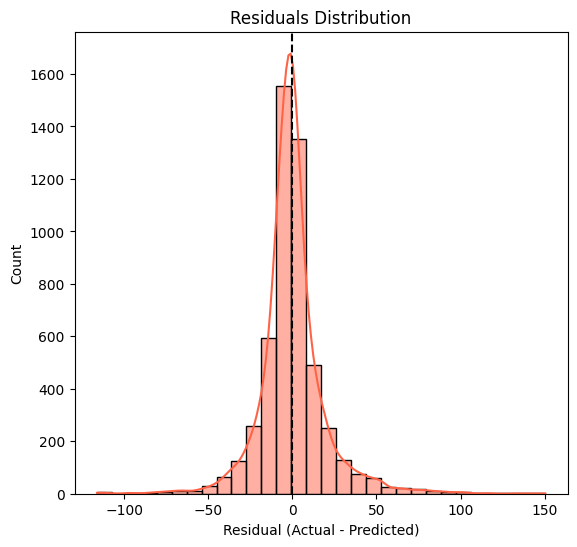

In [50]:
# Residuals
residuals = y_test - y_pred

# Residuals distribution plot
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(residuals, kde=True, bins=30, color='tomato')
plt.title('Residuals Distribution')
plt.xlabel('Residual (Actual - Predicted)')
plt.axvline(0, linestyle='--', color='black')

## Feature Importance from Random Forest

Feature importance indicates how relevant each feature is in predicting the target variable. In a Random Forest model, feature importance is computed by looking at how much each feature contributes to reducing the impurity (e.g., Gini impurity or entropy) at each split in the trees.

### 1. **Best Model Selection**:
- The best model is selected from the grid search results, which provides the optimal parameters (`n_estimators` and `max_depth`) for the Random Forest regressor.
```python
best_model = gs_model.best_estimator_


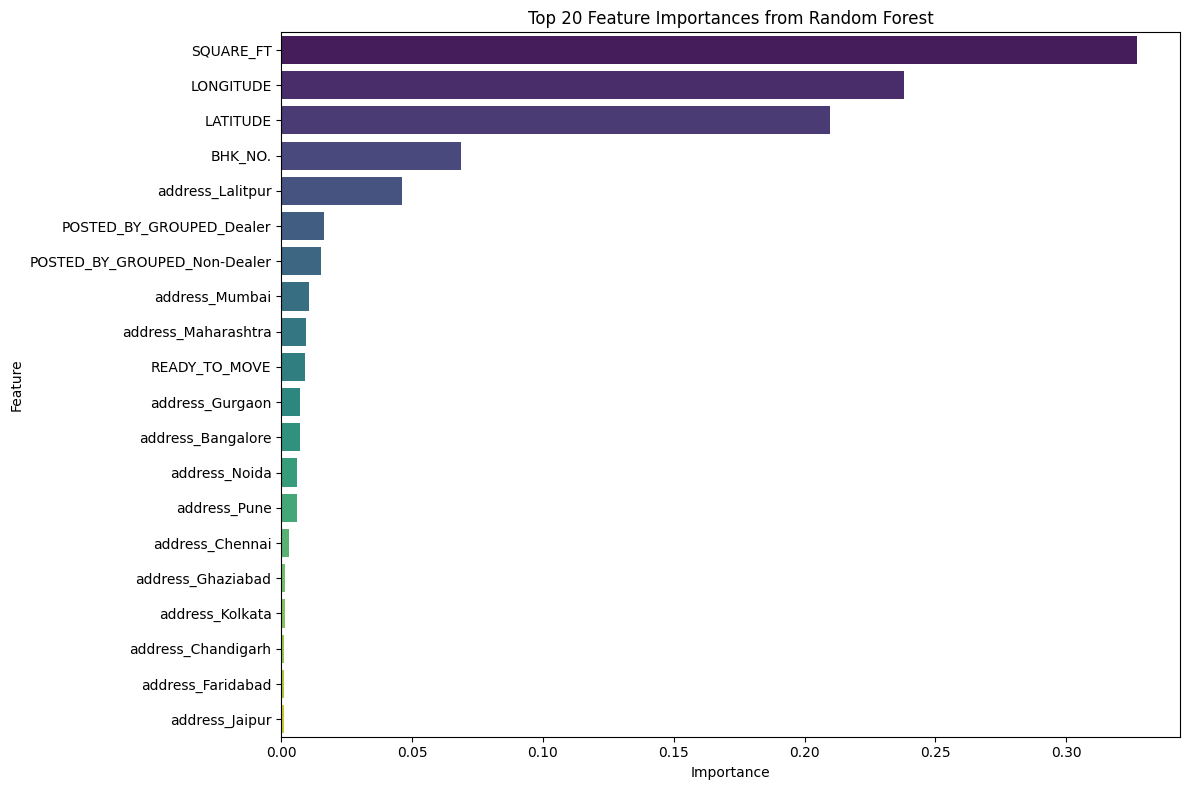

                          Feature  Importance
1                       SQUARE_FT    0.327123
3                       LONGITUDE    0.237978
4                        LATITUDE    0.209875
0                         BHK_NO.    0.068675
139              address_Lalitpur    0.046256
5        POSTED_BY_GROUPED_Dealer    0.016391
6    POSTED_BY_GROUPED_Non-Dealer    0.015329
155                address_Mumbai    0.010728
145           address_Maharashtra    0.009624
2                   READY_TO_MOVE    0.009113
86                address_Gurgaon    0.007233
28              address_Bangalore    0.007052
168                 address_Noida    0.005870
187                  address_Pune    0.005844
53                address_Chennai    0.003052
79              address_Ghaziabad    0.001468
131               address_Kolkata    0.001403
51             address_Chandigarh    0.001137
73              address_Faridabad    0.001080
104                address_Jaipur    0.001001


In [64]:
# Get the best estimator from GridSearchCV
best_model = gs_model.best_estimator_

# Extract the RandomForestRegressor from the pipeline
rf_model = best_model.named_steps['regressor']

# Get feature importances
importances = rf_model.feature_importances_

# Get feature names from the preprocessor
# For numerical features (after RobustScaler)
num_features_transformed = num_features  # since RobustScaler doesn't change feature count

# For categorical features (after OneHotEncoder)
cat_pipeline = best_model.named_steps['preprocessor'].named_transformers_['cat']
ohe = cat_pipeline.named_steps['onehotencoder']
cat_features_transformed = ohe.get_feature_names_out(cat_features)

# Combine all feature names
all_feature_names = np.concatenate([num_features_transformed, cat_features_transformed])

# Create a DataFrame for feature importances
feature_importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': importances
}).sort_values('Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(20), palette='viridis')
plt.title('Top 20 Feature Importances from Random Forest')
plt.tight_layout()
plt.show()

# You can also print the feature importances
print(feature_importance_df.head(20))

## Saving the Best Model

Once we have the best model identified through GridSearchCV, we save it for future use, avoiding the need to retrain the model each time.

### 1. **Extracting the Best Model**:
The `best_estimator_` attribute from the `GridSearchCV` object contains the best performing model, which includes the optimal hyperparameters found during the grid search process. We extract this model.


In [66]:
# Save the best model from GridSearchCV
best_model = gs_model.best_estimator_
dump(best_model, 'best_model.joblib')

['best_model.joblib']

## Function: `make_predictions`

This function generates predictions on a given test dataset using a previously trained and serialized model. It takes in the path to the test data and the path to the serialized model, cleans the test data, loads the model, and then generates and returns the predictions.

### Function Parameters:
- **test_data_path** (str): 
  - The path to the test dataset (CSV file) that contains the data you want to make predictions on.
  
- **model_path** (str): 
  - The path to the serialized model file (e.g., `.joblib` or `.pkl`) that will be used for generating predictions.

### Function Return:
- **pd.Series**: 
  - A Pandas Series containing the predictions, indexed by the test data's index. The name of the Series is `'predictions'`

In [68]:
def make_predictions(test_data_path: str, model_path: str) -> pd.Series:
    """
    Generate predictions using a serialized model on cleaned test data.
    
    Parameters:
    -----------
    test_data_path : str
        Path to CSV file containing test data
    model_path : str
        Path to serialized model file (.joblib or .pkl)
    
    Returns:
    --------
    pd.Series
        Series containing predictions
    """
    # 1. Load and clean test data
    test_data = wrangle(test_data_path)
    
    # 2. Load serialized model
    model = load(model_path)
    
    # 3. Generate predictions
    predictions = model.predict(test_data)
    
    # 4. Convert to Series with appropriate name
    return pd.Series(predictions, name='predictions', index=test_data.index)

## Making Final Predictions on Test Data

In this step, we use the `make_predictions` function to generate predictions on the test dataset provided in the competition. We pass the file path of the test data and the path to the trained model file.


In [69]:
predictions = make_predictions('/kaggle/input/house-price-prediction-challenge/test.csv', 'best_model.joblib')

Shape: (68720, 11)
       UNDER_CONSTRUCTION          RERA       BHK_NO.     SQUARE_FT  \
count        68720.000000  68720.000000  68720.000000  6.872000e+04   
mean             0.176557      0.316531      2.388198  2.762419e+03   
std              0.381296      0.465126      0.864577  1.640991e+05   
min              0.000000      0.000000      1.000000  1.000000e+00   
25%              0.000000      0.000000      2.000000  9.000310e+02   
50%              0.000000      0.000000      2.000000  1.174982e+03   
75%              0.000000      1.000000      3.000000  1.550265e+03   
max              1.000000      1.000000     31.000000  4.016393e+07   

       READY_TO_MOVE        RESALE     LONGITUDE      LATITUDE  
count   68720.000000  68720.000000  68720.000000  68720.000000  
mean        0.823443      0.933498     21.288045     76.919388  
std         0.381296      0.249159      6.179034     10.100950  
min         0.000000      0.000000    -38.391261   -118.354100  
25%         1.00

In [78]:
predictions.to_csv('submission.csv', index=False)

In [79]:
predictions.head()

0    13.976533
1    68.794370
2    67.229149
3    43.279744
4    11.877319
Name: predictions, dtype: float64